# Notebook Notes
---
This notebook shouldn't be run all at once, as it will need your input at several places. <del> The second cell creates a button that lets you select your file, and must be used before you can proceed.</del>  The Sixth cell has the relevant fit parameters that will need to be changed.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

In [2]:
# This cell is currently non-functional.  The Jupyter interface for using the file widget isn't installed by default.

#from ipywidgets import FileUpload
#if 'f_upload' in locals():
#    del(f_upload)
#f_upload = FileUpload(accept='.tsv', multiple=False )
#display(f_upload)

In [3]:
#data_filename = f_upload.value[list(f_upload.value.keys())[0]]['metadata']['name']
data_filename = 'Example4_Data.tsv' 
# You will have to enter your filename manually; make sure it is in the same directory as this script

with open(data_filename ,"r") as f:
    for x,line in enumerate(f):
        if(line == 'Channel Data:\n'): #reads the file until it finds this text, which always occurs two lines before the data starts
            data_start = x+2
            print("Data starts on row {}".format(data_start))
            break

data = np.loadtxt( data_filename , unpack=True, skiprows = data_start,delimiter= "\t",usecols=[0,2]) #numpy opens the data starting at the appropriate place
# Change the delimiter to "," if you have a .csv file

channel = data[0]
if(len(data)==2): # If you didn't calibrate the energies, the second row contains the particle counts
    N = data[1]
else:
    Energy = data[1]
    N = data[2]

dN = np.sqrt(N)
for i, value in enumerate(dN):
    if value == 0:
        dN[i] = 1.14

Data starts on row 22


In [4]:
def gaussianfunc(p,x):
    return p[0]/(p[2]*np.sqrt(2*np.pi))*np.exp(-(x-p[1])**2/(2*p[2]**2))

def linearfunc(p,x):
    return p[0]*x + p[1]

def gaussianlinear(p,x):
    return gaussianfunc(p[0:3],x) + linearfunc(p[3:5],x)

def residual(p,func, xvar, yvar, err):
    return (func(p, xvar) - yvar)/err

In [5]:
# The code below defines our data fitting function.
# Inputs are:
# initial guess for parameters p0
# the function we're fitting to
# the x,y, and dy variables
# tmi can be set to 1 or 2 if more intermediate data is needed

def data_fit(p0, func, xvar, yvar, err, tmi=0):
    try:
        fit = optimize.least_squares(residual, p0, args=(func,xvar, yvar, err), verbose=tmi)
    except Exception as error:
        print("Something has gone wrong:",error)
        return p0, np.zeros_like(p0), np.nan, np.nan
    pf = fit['x']

    print()

    try:
        cov = np.linalg.inv(fit['jac'].T.dot(fit['jac']))          
        # This computes a covariance matrix by finding the inverse of the Jacobian times its transpose
        # We need this to find the uncertainty in our fit parameters
    except:
        # If the fit failed, print the reason
        print('Fit did not converge')
        print('Result is likely a local minimum')
        print('Try changing initial values')
        print('Status code:', fit['status'])
        print(fit['message'])
        return pf, np.zeros_like(pf), np.nan, np.nan
            #You'll be able to plot with this, but it will not be a good fit.

    chisq = sum(residual(pf, func, xvar, yvar, err) **2)
    dof = len(xvar) - len(pf)
    red_chisq = chisq/dof
    pferr = np.sqrt(np.diagonal(cov)) # finds the uncertainty in fit parameters by squaring diagonal elements of the covariance matrix
    print('Converged with chi-squared {:.2f}'.format(chisq))
    print('Number of degrees of freedom, dof = {:.2f}'.format(dof))
    print('Reduced chi-squared {:.2f}'.format(red_chisq))
    print()
    Columns = ["Parameter #","Initial guess values:", "Best fit values:", "Uncertainties in the best fit values:"]
    print('{:<11}'.format(Columns[0]),'|','{:<24}'.format(Columns[1]),"|",'{:<24}'.format(Columns[2]),"|",'{:<24}'.format(Columns[3]))
    for num in range(len(pf)):
        print('{:<11}'.format(num),'|','{:<24.3e}'.format(p0[num]),'|','{:<24.3e}'.format(pf[num]),'|','{:<24.3e}'.format(pferr[num]))
    return pf, pferr, chisq,dof

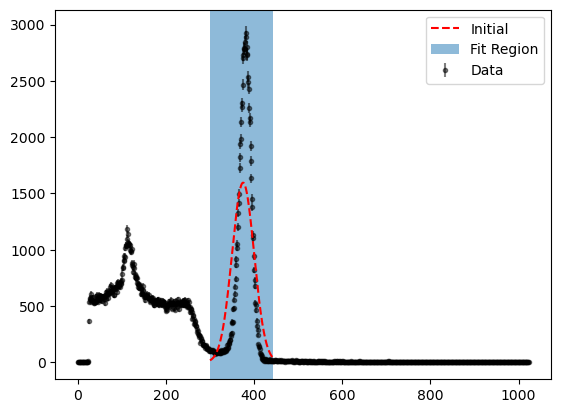

In [6]:
min_value = 300
max_value = 444
count_estimate = 100000
center_estimate = 375
width_estimate = 25
slope = 0
offset = 0

fig,ax = plt.subplots()
ax.errorbar(channel, N, dN, fmt='k.',alpha = 0.5,label='Data')
p02 = [count_estimate, center_estimate , width_estimate,slope,offset]
channel_cont = np.linspace(min_value, max_value , 5000)
ax.plot(channel_cont, gaussianlinear(p02, channel_cont), 'r--', label='Initial',zorder=10)
ax.axvspan(min_value ,max_value,label='Fit Region',alpha = 0.5)
ax.legend()

Gaussian only

Converged with chi-squared 4739.98
Number of degrees of freedom, dof = 141.00
Reduced chi-squared 33.62

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 1.000e+05                | 9.408e+04                | 3.067e+02               
1           | 3.750e+02                | 3.794e+02                | 4.489e-02               
2           | 2.500e+01                | 1.367e+01                | 3.374e-02               


Gaussian with linear background

Converged with chi-squared 546.68
Number of degrees of freedom, dof = 139.00
Reduced chi-squared 3.93

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 1.000e+05                | 8.988e+04                | 3.143e+02               
1           | 3.750e+02                | 3.798e+02                | 4.633e-02               
2           | 2.500e+01                | 1.287e+01               

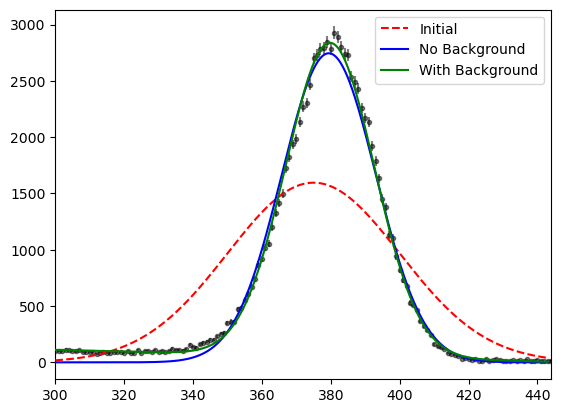

In [7]:
fig,ax = plt.subplots()
ax.errorbar(channel, N, dN, fmt='k.',alpha = 0.5)
ax.set_xlim(min_value,max_value)

channel2 = channel[min_value:max_value]
N2 = N[min_value:max_value]
dN2 = dN[min_value:max_value]

p0 = [count_estimate, center_estimate , width_estimate]
channel_cont = np.linspace(min(channel2), max(channel2), 5000)
ax.plot(channel_cont, gaussianfunc(p0, channel_cont), 'r--', label='Initial',zorder=10)

print("Gaussian only")
pf1, pferr1, chisq1, dof1 = data_fit(p0, gaussianfunc, channel2, N2, dN2)
ax.plot(channel_cont, gaussianfunc(pf1, channel_cont), 'b-', label='No Background',zorder=11)

print("\n\nGaussian with linear background")
p02 = [count_estimate, center_estimate , width_estimate,slope,offset]
pf2, pferr2, chisq2, dof2 = data_fit(p02, gaussianlinear, channel2, N2, dN2)
ax.plot(channel_cont, gaussianlinear(pf2, channel_cont), 'g-', label='With Background',zorder=11)

ax.legend()

----